# Классификация ответов

### Подключение библиотек

In [1]:
# Библиотеки для работы с файлами и обработки текста
import jsonlines
from nltk.tokenize import word_tokenize 
import pymorphy2 
import string, re 

# Библиотеки для анализа данных
import pandas as pd 
from difflib import SequenceMatcher
import numpy as np
import itertools

# Библиотеки для визуализации данных
import matplotlib.pyplot as plt  # Для создания графиков
import seaborn as sns  # Библиотека для визуализации данных на основе matplotlib
from wordcloud import WordCloud  # Для создания облака слов

# Библиотеки для обработки естественного языка (NLP)
from nltk.corpus import stopwords 
from sklearn.feature_extraction.text import TfidfVectorizer

# Библиотеки для машинного обучения
from sklearn.metrics import *  # Различные метрики для оценки результатов классификации
from sklearn.pipeline import Pipeline  # Построение конвейера для обработки данных
from sklearn.model_selection import GridSearchCV  # Поиск по сетке параметров для выбора наилучших параметров модели
from sklearn.linear_model import LogisticRegression  # Логистическая регрессия
from sklearn.ensemble import RandomForestClassifier  # Случайный лес

# Библиотеки для обработки текста и модели для NLP
import gensim
from collections import defaultdict

# Использование готовых моделей
from transformers import pipeline

##### Считываем данные с файла и создаем словарь data

In [2]:
data = {}
with jsonlines.open('train.jsonl') as file:
    for line in file:
        idx = line['idx']
        text = line['passage']['text']
        questions = []
        answers = []
        labels = []
        for question_entry in line['passage']['questions']:
            question = question_entry['question']
            ans_texts = [answer_entry['text'] for answer_entry in question_entry['answers']]
            ans_labels = [answer_entry['label'] for answer_entry in question_entry['answers']]
            questions.append(question)
            answers.append(ans_texts)
            labels.append(ans_labels)
        data[idx] = {'text': text, 'questions': questions, 'answers': answers, 'labels': labels}
data

{0: {'text': '(1) Но люди не могут существовать без природы, поэтому в парке стояли железобетонные скамейки — деревянные моментально ломали. (2) В парке бегали ребятишки, водилась шпана, которая развлекалась игрой в карты, пьянкой, драками, «иногда насмерть». (3) «Имали они тут и девок...» (4) Верховодил шпаной Артемка-мыло, с вспененной белой головой. (5) Людочка сколько ни пыталась усмирить лохмотья на буйной голове Артемки, ничего у неё не получалось. (6) Его «кудри, издали напоминавшие мыльную пену, изблизя оказались что липкие рожки из вокзальной столовой — сварили их, бросили комком в пустую тарелку, так они, слипшиеся, неподъёмно и лежали. (7) Да и не ради причёски приходил парень к Людочке. (8) Как только её руки становились занятыми ножницами и расчёской, Артемка начинал хватать её за разные места. (9) Людочка сначала увёртывалась от хватких рук Артемки, а когда не помогло, стукнула его машинкой по голове и пробила до крови, пришлось лить йод на голову «ухажористого человека».

##### Функция обработки текста

In [3]:
def preprocess_text(text):
    # Разбиваем текст на токены (слова и предложения)
    tokens = word_tokenize(text.lower(), language='russian')  # Приводим к нижнему регистру
    # Удаление чисел внутри скобок из списка
    text_without_numbers = []
    inside_brackets = False
    for word in tokens:
        if word == '(':
            inside_brackets = True
        elif word == ')':
            inside_brackets = False
        text_without_numbers.append(re.sub(r'\d+', '', word) if inside_brackets else word)
    tokens = text_without_numbers
    # Уберем знаки препинания
    tokens = [''.join(c for c in w if c not in string.punctuation + "«–»…") for w in tokens]
    # Удаление пустых строк из списка
    tokens = [word for word in tokens if word]
    if not bool(tokens):
        return [' ']
    return tokens

### Разведочный анализ данных

##### Формируем статистические данные по каждому ответу в виде DataFrame

word_text - Количество слов в тексте;
word_question - Количество слов в вопросе;
word_answer - Количество слов в ответе;
%question_in_text - Схожесть вопроса и текста;
%answer_in_text - Схожесть ответа и текста;
label - метка ответа (1 или 0).

Схожесть - отношение количества слов, которые есть и строке и в тексте, к общему числу слов в строке.

In [4]:
#3 списка будут использоваться для построения облаков слов
all_texts_data = [] 
all_questions_data = []
all_answers_data = []

def similarity(text, line):
    return sum([1 for word in line if word in text]) / len(line) if line and any(word in text for word in line) else 0
        
#Создание Df и извлечение данных из data
col_names =  ['idx', 'word_text', 'word_question', 'word_answer', '%question_in_text', '%answer_in_text', 'label']
stat_df  = pd.DataFrame(columns = col_names)
for key in data:
    text = preprocess_text(data[key]['text'])
    all_questions = data[key]['questions']
    all_answers = data[key]['answers']
    all_labels = data[key]['labels']
    all_texts_data += text 
    for i in range(len(all_questions)):
        question = preprocess_text(all_questions[i])
        all_questions_data += question
        for j in range(len(all_answers[i])):
            answer = preprocess_text(all_answers[i][j])
            label = all_labels[i][j]
            #Заполнение Df
            stat_df.loc[len(stat_df.index)] = [key, len(text), len(question), len(answer), similarity(text, question), similarity(text, answer), label]
            all_answers_data += answer
stat_df

,idx,word_text,word_question,word_answer,%question_in_text,%answer_in_text,label
0,0.0,161.0,3.0,2.0,0.333333,1.000000,1.0
1,0.0,161.0,3.0,2.0,0.333333,0.500000,0.0
2,0.0,161.0,3.0,2.0,0.333333,0.000000,0.0
3,0.0,161.0,4.0,4.0,0.000000,0.250000,1.0
4,0.0,161.0,4.0,3.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...
11945,499.0,168.0,12.0,5.0,0.583333,0.800000,0.0
11946,499.0,168.0,12.0,18.0,0.583333,0.833333,1.0
11947,499.0,168.0,12.0,8.0,0.583333,0.750000,0.0
11948,499.0,168.0,12.0,14.0,0.583333,0.500000,0.0


##### Визуализируем зависимости

                idx     word_text  word_question   word_answer  \
count  11950.000000  11950.000000   11950.000000  11950.000000   
mean     220.043180    190.998912       7.799916      5.371632   
std      148.128668     47.805520       3.413807      5.907909   
min        0.000000     96.000000       2.000000      1.000000   
25%       77.000000    165.000000       5.000000      2.000000   
50%      209.000000    186.000000       7.000000      3.500000   
75%      347.000000    201.000000       9.000000      7.000000   
max      499.000000    510.000000      27.000000    133.000000   

       %question_in_text  %answer_in_text         label  
count       11950.000000     11950.000000  11950.000000  
mean            0.598600         0.614758      0.450377  
std             0.223510         0.362153      0.497552  
min             0.000000         0.000000      0.000000  
25%             0.444444         0.333333      0.000000  
50%             0.625000         0.666667      0.000000  

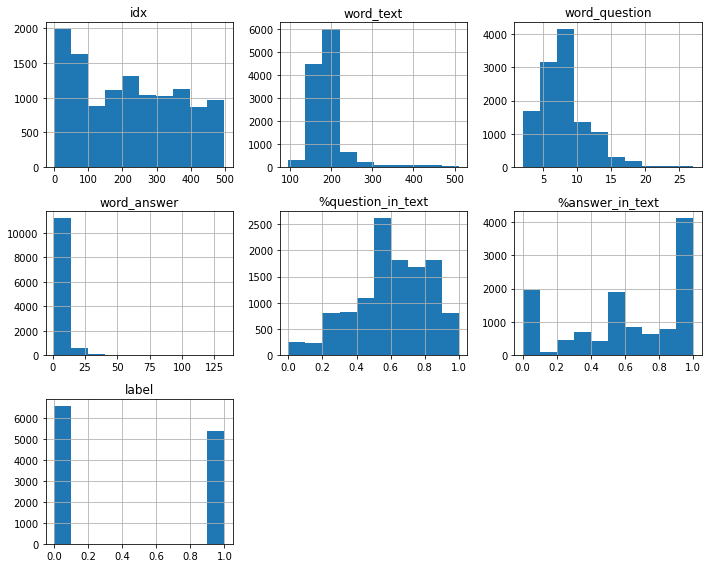

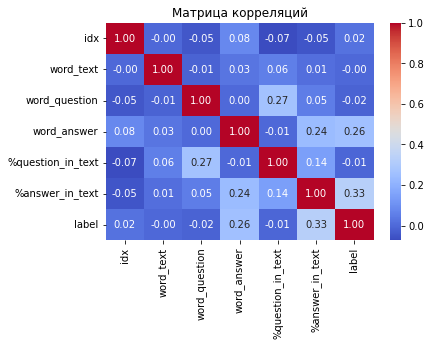

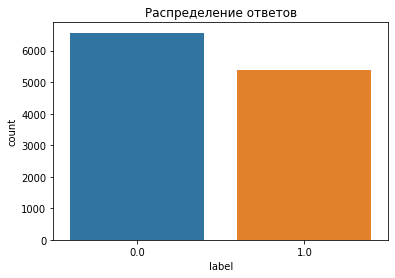

In [5]:
print(stat_df.describe())

# Гистограммы распределения числовых признаков
stat_df.hist(figsize=(10, 8))
plt.tight_layout()
plt.show()

correlation_matrix = stat_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Матрица корреляций')
plt.show()

sns.countplot(x='label', data=stat_df)
plt.title('Распределение ответов')
plt.show()

Из матрицы корреляции видно, что положительная линейная связь, относительно метки ответа, наблюдается у двух признаков word_answer и %answer_in_text.
Т.е чем больше слов в ответе и чем больше схожесть ответа с текстом, то тем более вероятно, что ответ верный.
Максимальное число слов в ответе составило 133 (ответы были представленны в виде текста письма, о котором было сказано в вопросе.).
Неверных ответов больше, чем верных.

##### Облака слов

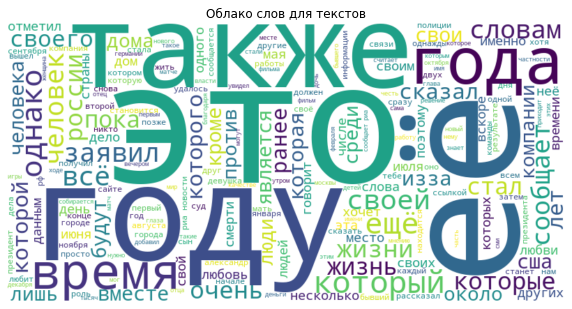

In [6]:
stop_words = stopwords.words('russian')
wordcloud = WordCloud(stopwords=stop_words, width=800, height=400, background_color='white').generate(' '.join(all_texts_data))

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов для текстов')
plt.show()


Из слов "Россия", "CША", "РИА Новости", "сообщает", можно сделать вывод: что значительная часть взята из новостной информации.

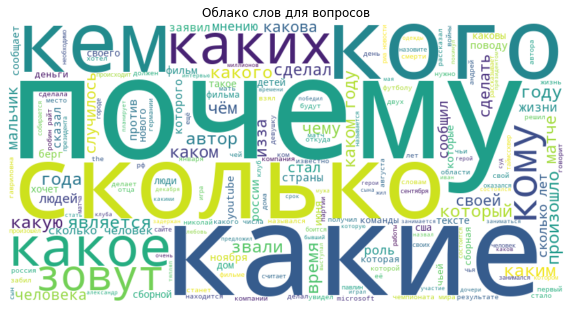

In [7]:
wordcloud = WordCloud(stopwords=stop_words, width=800, height=400, background_color='white').generate(' '.join(all_questions_data))

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов для вопросов')
plt.show()

Логично, что в облаке вопросов будут доминировать вопросительные местоимения. ("Какие?", "Почему?", "Сколько?")

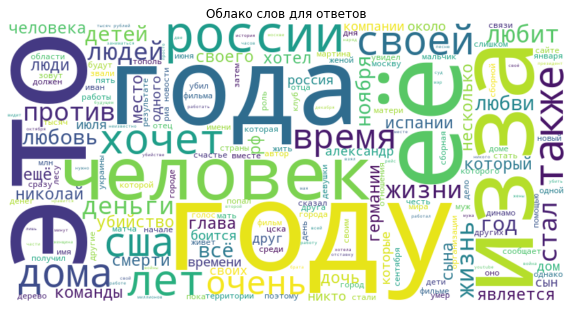

In [8]:
wordcloud = WordCloud(stopwords=stop_words, width=800, height=400, background_color='white').generate(' '.join(all_answers_data))

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов для ответов')
plt.show()

Облако ответов потдверждает, что в данном наборе много текстов на новостную тематику.

### Обучение модели

##### Формирование данных

In [9]:
texts_for_training = []
def get_data(data_json_file, mode='train'):
    X, Y = [], []
    with jsonlines.open(data_json_file) as file:
        for line in file:
            item = line
            text = preprocess_text(item['passage']['text'])
            if mode == 'bert_test':
                text = ' '.join(text)
            global texts_for_training
            texts_for_training += text
            questions = item['passage']['questions']
            for q in questions:
                bert_answers = []
                question = ' '.join(preprocess_text(q['question']))
                answers = q['answers']
                for a in answers:
                    answer = ' '.join(preprocess_text(a['text']))
                    if mode != 'bert_test':
                        X.append(' Question: ' + question + ' Answer: ' + answer)
                    else:
                        bert_answers.append(answer)
                    if mode != 'result':
                        label = a['label']
                        Y.append(label)
                if mode == 'bert_test':
                    X.append([text, question, bert_answers])
    if mode == 'result':
        return X
    return X, Y

In [10]:
X_train, y_train = get_data('train.jsonl', mode='train') # Данные для обучения
X_test, y_test = get_data('val.jsonl', mode='test') # Данные для проверки
X_result = get_data('test.jsonl', mode='result') # Данные, для которых нужно провести классификацию
X_bert_test, y_bert_test = get_data('val.jsonl', mode='bert_test') # Данные для работы с готовой моделью

##### Опишем класс векторизациии TfidfEmbeddingVectorizer на основе Word2vec со схемой взвешивания tf-idf

[Пример реализации и использования TfidfEmbeddingVectorizer](http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/)

In [11]:
model = gensim.models.Word2Vec(texts_for_training, vector_size=100, window=5, min_count=1, workers=4)
w2v = dict(zip(model.wv.index_to_key, model.wv.vectors))

class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(word2vec.values())

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

{'clf__C': 10, 'clf__solver': 'liblinear'}
Precision:   0.58
Recall:   0.56
F1-measure:   0.55
Accuracy:   0.59
              precision    recall  f1-score   support

           0       0.60      0.78      0.68      1242
           1       0.56      0.34      0.42       993

    accuracy                           0.59      2235
   macro avg       0.58      0.56      0.55      2235
weighted avg       0.58      0.59      0.57      2235



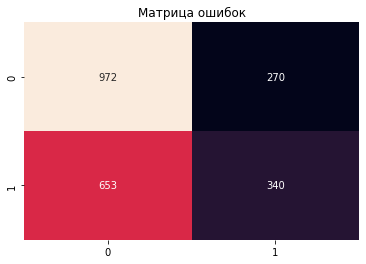

{'clf__max_depth': 20, 'clf__min_samples_leaf': 4, 'clf__n_estimators': 100}
Precision:   0.57
Recall:   0.55
F1-measure:   0.54
Accuracy:   0.58
              precision    recall  f1-score   support

           0       0.59      0.81      0.68      1242
           1       0.56      0.30      0.39       993

    accuracy                           0.58      2235
   macro avg       0.57      0.55      0.54      2235
weighted avg       0.58      0.58      0.55      2235



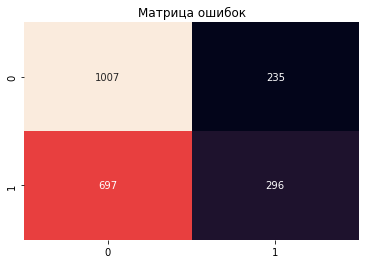

CPU times: total: 5min 9s
Wall time: 6min 22s


In [12]:
%%time
# Параметры для моделей
param_grid_lr = {
    'clf__C': [0.1, 1, 10],
    'clf__solver': ['liblinear']
}

param_grid_rf = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [10, 20],
    'clf__min_samples_leaf': [1, 2, 4]
}
results_model = []
def train_and_evaluate_model(model, param_grid, X_train, y_train, X_test, y_test):
    pipeline = Pipeline([
        ('vect', TfidfEmbeddingVectorizer(w2v)),
        ('clf', model)
    ])
    scorer = make_scorer(f1_score, average='weighted')
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring=scorer)
    grid_search.fit(X_train, y_train)
    predictions = grid_search.predict(X_test)
    global results_model
    results_model.append(grid_search.best_estimator_)
    print(grid_search.best_params_)
    print("Precision: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
    print("Recall: {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
    print("F1-measure: {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
    print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, predictions)))
    print(classification_report(y_test, predictions))
    labels = grid_search.best_estimator_['clf'].classes_
    sns.heatmap(data=confusion_matrix(y_test, predictions), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
    plt.title("Матрица ошибок")
    plt.show()


models = [
    LogisticRegression(max_iter=1000, random_state=17),
    RandomForestClassifier(random_state=17, n_jobs=-1)
]

param_grids = [param_grid_lr, param_grid_rf]

for model, param_grid in zip(models, param_grids):
    train_and_evaluate_model(model, param_grid, X_train, y_train, X_test, y_test)

Precision (Точность): Эта метрика важна, когда стоим перед задачей минимизации ложноположительных предсказаний. В конкретной задаче, где классифицируются данные на верные и неверные ответы, важно не допустить, чтобы модель часто ошибалась, указывая на верные ответы там, где их на самом деле нет.

Recall (Полнота): Она фокусируется на максимизации числа истинных положительных результатов и минимизации пропущенных положительных случаев. В данном контексте, когда важно учесть все верные ответы, даже если модель совершает ошибки, полнота становится критически важной.

F1-score (F1-мера): Это гармоническое среднее между точностью и полнотой. Позволяет балансировать между двумя предыдущими метриками. Она хорошо работает в случаях, когда классы несбалансированы и когда нам необходимо найти компромисс между точностью и полнотой.

Точность классификации (Accuracy): Это общая доля правильно классифицированных экземпляров, и она может быть полезна в случае сбалансированных классов. В нашем случае, исходя из тестового набора, можно судить что классы отличаются на 20-25%. Поэтому основной метрикой была выбрана F1 мера.

### Формирование ответов

##### Базовой моделью выбираем логистическую регрессию, т.к F1-мера у нее лучше.

In [24]:
base_model = results_model[0]

In [25]:
%%time
predict = base_model.predict(X_result)

CPU times: total: 2.14 s
Wall time: 2.16 s


In [26]:
result_df = pd.DataFrame({'id':X_result ,'label':predict})
result_df = result_df.drop_duplicates()
result_df

,id,label
0,Question: о чем дневник анны франк Answer: дн...,0
1,Question: о чем дневник анны франк Answer: дн...,0
2,Question: о чем дневник анны франк Answer: о ...,0
3,Question: о чем дневник анны франк Answer: ан...,0
4,Question: каким будет приложение anne frank a...,0
...,...,...
7609,Question: в чём обвинил суд руслана тихонова ...,0
7610,Question: сколько в среднем стоило заказать д...,0
7611,Question: сколько в среднем стоило заказать д...,0
7612,Question: сколько в среднем стоило заказать д...,0


In [27]:
result_df = result_df.drop_duplicates()
result_df.to_csv('Submission.csv', index=False)

# Используем готовые модели

Для решения нашей задачи мы можем использовать готовые модели, специализированные на вопросно-ответных системах. В этом подходе отсутствует этап обучения, и модель, на основе вопроса и контекста, сразу предоставляет ответ. После этого мы проводим сравнение полученного ответа с данными в нашем наборе, что позволяет классифицировать ответы как правильные или неправильные. Этот метод позволяет быстро внедрить систему вопросно-ответных задач без необходимости обучения модели, а анализ результатов помогает определить точность классификации ответов.

### BERT

Модель mdeberta-v3-base-squad2 - это модель ответов на вопросы, которая была доработана для 3 эпох в наборе данных SQuAD2.0. Она основана на DeBERTa, которая улучшает модели BERT и RoBERTa, используя рассеянное внимание и усовершенствованные методы декодирования масок. В версии mDeBERTa V3 предварительное обучение в стиле ELECTRA с разделением градиентного встраивания используется для дальнейшего повышения эффективности и производительности модели при выполнении последующих задач. Модель состоит из 12 слоев, скрытого размера 768 и словарного запаса, содержащего 250 ТЫС. токенов. Она была обучена с использованием 2,5 Т многоязычных данных CC100.


[Пример реализиции и подключения модели](https://habr.com/ru/articles/740308/)

In [17]:
question = 'Когда будем убирать лёд?'
context = ('Вчера выпало много снега, а сегодня из-за'
         ' тёплой погоды он подтаял и заледенел.'
         ' Придётся на выходных взять лом и немного разбить лёд.')

model_pipeline = pipeline(
   task='question-answering',
   model='timpal0l/mdeberta-v3-base-squad2'
)

model_pipeline(question=question, context=context)['answer']

Object `снег` not found.


' на выходных'

Для сравнения ответов будем использовать коэффициент Жаккара. Он более подходит в рамках бинарной классификации, чем векторные сравнения. Используя коэффициент Жаккара, мы можетм измерить схожесть между множествами слов в ответе модели и правильным ответом. Таким образом, можно определить, насколько ответ модели соответствует правильному ответу в терминах пересечения слов.

In [18]:
def compare_texts(text1, text2):
    set1 = set(text1)
    set2 = set(text2)
    jaccard_coefficient = len(set1.intersection(set2)) / len(set1.union(set2))
    return jaccard_coefficient

In [19]:
%%time
jaccard_bert = []
for element in X_bert_test:
    text = element[0]
    question = element[1]
    answers = element[2]
    answer2 = model_pipeline(question=question, context=text)['answer']
    for answer in answers:
        jaccard_coefficient = compare_texts(answer2, answer)
        jaccard_bert.append(jaccard_coefficient)

CPU times: total: 1h 45min 59s
Wall time: 17min 41s


##### На основе коэффициента проводим классификацию

In [20]:
test_bert = [1 if i >= 0.54 else 0 for i in jaccard_bert]

##### Оцениваем результаты

Precision:   0.66
Recall:   0.64
F1-measure:   0.64
Accuracy:   0.66
              precision    recall  f1-score   support

           0       0.66      0.78      0.72      1242
           1       0.65      0.50      0.57       993

    accuracy                           0.66      2235
   macro avg       0.66      0.64      0.64      2235
weighted avg       0.66      0.66      0.65      2235



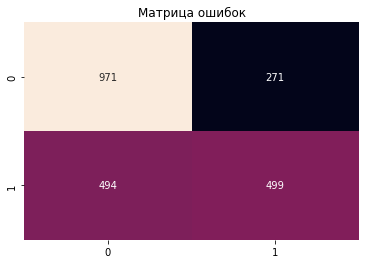

In [21]:
print("Precision: {0:6.2f}".format(precision_score(y_test, test_bert, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, test_bert, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, test_bert, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, test_bert)))
print(classification_report(y_test, test_bert))
labels = [0, 1]
sns.heatmap(data=confusion_matrix(y_test, test_bert), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Матрица ошибок")
plt.show()

# Выводы

In [23]:
len(X_test) # Количество проверочных значений и количество ответов "скормленных" BERTу.

2235

При использовании готовой модели произошло значительное улучшение F1-меры, что свидетельствует о более высоком качестве предсказаний. Однако, стоит отметить, что при этом увеличилось время, необходимое для получения готового списка результатов. В сравнении с этим, наша собственная модель была обучена за относительно короткое время в 6 минут, включая выбор между различными моделями, такими как линейная регрессия и случайный лес, а также подбор наилучших параметров для каждой из них. Вывод для 7614 значений составил всего 2 секунды.

Однако, при использовании BERT, время расчета для 2235 значений значительно увеличилось до 18 минут. Наша модель, напротив, была нацелена на обработку больших объемов данных с оптимальным балансом между временем и качеством.

#### В итоге, выбор между готовой моделью, такой как BERT, и нашей моделью зависит от конкретных потребностей задачи и доступных ресурсов, при этом учитывая компромисс между точностью и временем выполнения.
